In [1]:
import numpy as np
import matplotlib.pyplot as plt

from config import DATA_FOLDER

%matplotlib inline

# Introduction

This notebook shows how to build PCA, K-means, and linear regression by `numpy` only. It also demonstrates the phonemonon of overfitting as the number of features increases.

In [2]:
class PCA:
    def fit(self, X: np.array, normalize: bool = True, components: int = 20) -> None:
        if components > X.shape[1] or components <= 0:
            raise ValueError(
                "Number of Components should be between [1, {0}]".format(X.shape[1])
            )
        if normalize:
            X = (X - np.min(X)) / (np.max(X) - np.min(X))

        self.mean_X = np.mean(X, axis=0)
        self.centered_X = X - self.mean_X

        self.covariance_X = np.dot(self.centered_X.T, self.centered_X) / X.shape[0]

        self.components, self.singular_values, v = np.linalg.svd(self.covariance_X)

        # Sort sigular values and components.
        idx = np.argsort(self.singular_values)[::-1]
        self.singular_values = self.singular_values[idx]
        self.components = self.components[:, idx]

        self.reduced_components = self.components[:, 0:components]

    def transform(self, X: np.array, normalize: bool = True) -> np.array:
        if normalize:
            X = (X - np.min(X)) / (np.max(X) - np.min(X))

        centered_X = X - np.mean(X, axis=0)
        return np.dot(centered_X, self.reduced_components)

    def inverse_transform(self, X: np.array) -> np.array:
        return np.dot(X, self.reduced_components.T) + self.mean_X


class KMeans:
    def __init__(
        self, n_clusters: int = 10, max_iter: int = 100, random_state: int = 42
    ):
        if n_clusters <= 0:
            raise ValueError("n_cluster cannot be less or equal to 0.")
        self.n_cluster = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state

    def fit(self, X: np.array, normalize=True):
        self._X_rows = X.shape[0]
        self._X_cols = X.shape[1]

        np.random.seed(self.random_state)

        if (
            self._X_rows == self.n_cluster
        ):  # deal with the case when number of rows is equal to number of clusters
            self.labels = np.random.choice(self.n_cluster, self._X_rows, replace=False)
        else:
            self.labels = np.random.choice(self.n_cluster, self._X_rows)

        if normalize:
            X = (X - np.min(X)) / (np.max(X) - np.min(X))

        self.centers = np.zeros((self.n_cluster, self._X_cols))

        self.iter = 0
        while self.iter < self.max_iter:
            for i in range(self.n_cluster):
                X_i = X[self.labels == i,]
                # if X is a vector, set center[i, 0] to X
                if X_i.ndim == 1:
                    self.centers[i,] = X_i
                # If X is empty, set center[i, ] to a zero vector.
                elif X_i.size == 0:
                    self.centers[i,] = np.zeros(self._X_cols)
                else:
                    self.centers[i,] = np.mean(X_i, axis=0)

            # Decide new groups.
            new_labels = np.zeros(self._X_rows)
            for i in range(self._X_rows):
                dist = np.nansum(np.square((X[i] - self.centers)), axis=1)
                new_labels[i] = np.argmin(dist)

            # Termination condition.
            if np.array_equal(self.labels, new_labels):
                break
            else:
                self.labels = new_labels
                self.iter += 1

        # Remove zero vectors (empty clusters) in centers
        self.centers = self.centers[~np.all(self.centers == 0, axis=1)]

    def transform(self, X, normalize=True):
        if normalize:
            X = (X - np.min(X)) / (np.max(X) - np.min(X))

        return np.apply_along_axis(self._compute_dist, 1, X)

    def _compute_dist(self, row):
        return np.mean(np.square(row - self.centers), axis=1)


class LinearRegression:
    def fit(self, X: np.array, y: np.array) -> None:
        # Obtain the weights using pseudo-inverse matrix.
        self.weights = np.linalg.pinv(X).dot(y)

    def predict(self, X: np.array) -> np.array:
        return X.dot(self.weights)


def mean_square_error(y_true_matrix: np.array, y_pred_matrix: np.array) -> float:
    return np.mean(np.square(y_true_matrix - y_pred_matrix))


def misclassification_rate(y_true: np.array, y_pred: np.array) -> float:
    return sum(y_true != y_pred) / len(y_pred)

# Load dataset and split the dataset into training and test subsets

In [3]:
X = np.loadtxt(DATA_FOLDER / "mfeat-pix.txt")

# Split the dataset into training data and test data.
train_indices = [range(0 + 200 * i, 100 + 200 * i) for i in range(10)]
test_indices = [range(100 + 200 * i, 200 + 200 * i) for i in range(10)]

X_train = X[train_indices,].reshape(1000, 240)
X_test = X[test_indices,].reshape(1000, 240)

# Create class labels.
# Since the class labels are ordered in both training and test data,
# we can use y_true for both training and test data.
nb_classes = 10
y_true = np.array([i for i in range(10) for j in range(100)])
y_true_matrix = np.eye(nb_classes)[y_true]  # One-hot encoding

# Perform dimension reduction on datasets by PCA

In [4]:
PCA_20 = PCA()
PCA_20.fit(X_train, components=20)

X_train_new = np.column_stack((np.ones(X_train.shape[0]), PCA_20.transform(X_train)))
X_test_new = np.column_stack((np.ones(X_test.shape[0]), PCA_20.transform(X_test)))

# Fit a linear model on the encoded training and test datasets

In [5]:
lr = LinearRegression()
lr.fit(X_train_new, y_true_matrix)
y_pred_matrix = lr.predict(X_train_new)
y_pred = np.argmax(y_pred_matrix, axis=1)

mse, miss = mean_square_error(y_true_matrix, y_pred_matrix), misclassification_rate(
    y_true, y_pred
)
print(f"Mean square error: {mse:.03}\nMissclassification rate: {miss:.03}")

Mean square error: 0.0366
Missclassification rate: 0.067


In [6]:
y_pred_matrix = lr.predict(X_test_new)
y_pred = np.argmax(y_pred_matrix, axis=1)

mse, miss = mean_square_error(y_true_matrix, y_pred_matrix), misclassification_rate(
    y_true, y_pred
)
print(f"Mean square error: {mse:.03}\nMissclassification rate: {miss:.03}")

Mean square error: 0.0374
Missclassification rate: 0.068


# Try different numbers of components and compare the performance

In [7]:
# Set maximum number of features create empty vectors
k_max = X.shape[1]
train_mse = np.zeros(k_max)
train_miss = np.zeros(k_max)
test_mse = np.zeros(k_max)
test_miss = np.zeros(k_max)

# Training models using different numbers of components
for i in range(k_max):
    PCA_mod = PCA()
    PCA_mod.fit(X_train, components=i + 1)
    X_train_new = np.column_stack(
        (np.ones(X_train.shape[0]), PCA_mod.transform(X_train))
    )
    X_test_new = np.column_stack((np.ones(X_test.shape[0]), PCA_mod.transform(X_test)))

    lr = LinearRegression()
    lr.fit(X_train_new, y_true_matrix)
    y_pred_matrix = lr.predict(X_train_new)
    y_pred = np.argmax(y_pred_matrix, axis=1)
    train_mse[i] = mean_square_error(y_true_matrix, y_pred_matrix)
    train_miss[i] = misclassification_rate(y_true, y_pred)

    y_pred_matrix = lr.predict(X_test_new)
    y_pred = np.argmax(y_pred_matrix, axis=1)
    test_mse[i] = mean_square_error(y_true_matrix, y_pred_matrix)
    test_miss[i] = misclassification_rate(y_true, y_pred)

As can be seen from the plot below, increasing the number of components used as features in the classification first resulted in a drastic decrease in both training and testing error. However, if the classifier flexibility continued to increase, the training erros would continue to decrease while the testing errors would increase. This is a typical overfitting phenomenon.

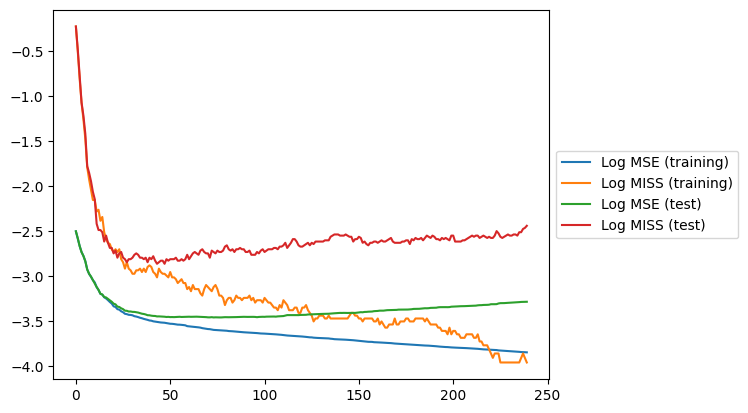

In [8]:
# Use log scale to give a clearer view of the separation between training and testing errors.
log_train_mse = np.log(train_mse)
log_train_miss = np.log(train_miss)
log_test_mse = np.log(test_mse)
log_test_miss = np.log(test_miss)

plt.plot(log_train_mse)
plt.plot(log_train_miss)
plt.plot(log_test_mse)
plt.plot(log_test_miss)

plt.legend(
    ["Log MSE (training)", "Log MISS (training)", "Log MSE (test)", "Log MISS (test)"],
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)
plt.show()

# Perform dimension reduction on datasets by K-means clustering

In addition to clustering, K-means can also be used for dimension reduction. The idea is to use the distances of each point between cluster centers as the new features.  

Note thatr the number of cluster centers can in fact be larger than the number of original features. So strictly speaking, K-means should be deemed as a feature generation method.

In [9]:
KMeans_20 = KMeans(n_clusters=20)
KMeans_20.fit(X_train)
X_train_new = np.column_stack((np.ones(X_train.shape[0]), KMeans_20.transform(X_train)))
X_test_new = np.column_stack((np.ones(X_test.shape[0]), KMeans_20.transform(X_test)))

In [10]:
lr = LinearRegression()
lr.fit(X_train_new, y_true_matrix)
y_pred_matrix = lr.predict(X_train_new)
y_pred = np.argmax(y_pred_matrix, axis=1)

mse, miss = mean_square_error(y_true_matrix, y_pred_matrix), misclassification_rate(
    y_true, y_pred
)
print(f"Mean square error: {mse:.03}\nMissclassification rate: {miss:.03}")

Mean square error: 0.0339
Missclassification rate: 0.062


In [11]:
lr = LinearRegression()
lr.fit(X_test_new, y_true_matrix)
y_pred_matrix = lr.predict(X_test_new)
y_pred = np.argmax(y_pred_matrix, axis=1)

mse, miss = mean_square_error(y_true_matrix, y_pred_matrix), misclassification_rate(
    y_true, y_pred
)
print(f"Mean square error: {mse:.03}\nMissclassification rate: {miss:.03}")

Mean square error: 0.034
Missclassification rate: 0.064


# Try different numbers of groups and compare the performance

In [12]:
# Set maximum number of features and create empty vectors
k_max = 200
train_mse = np.zeros(k_max)
train_miss = np.zeros(k_max)
test_mse = np.zeros(k_max)
test_miss = np.zeros(k_max)

for i in range(k_max):
    KMeans_mod = KMeans(n_clusters=i + 1)
    KMeans_mod.fit(X_train)
    X_train_new = np.column_stack(
        (np.ones(X_train.shape[0]), KMeans_mod.transform(X_train))
    )
    X_test_new = np.column_stack(
        (np.ones(X_test.shape[0]), KMeans_mod.transform(X_test))
    )

    lr = LinearRegression()
    lr.fit(X_train_new, y_true_matrix)
    y_pred_matrix = lr.predict(X_train_new)
    y_pred = np.argmax(y_pred_matrix, axis=1)
    train_mse[i] = mean_square_error(y_true_matrix, y_pred_matrix)
    train_miss[i] = misclassification_rate(y_true, y_pred)

    y_pred_matrix = lr.predict(X_test_new)
    y_pred = np.argmax(y_pred_matrix, axis=1)
    test_mse[i] = mean_square_error(y_true_matrix, y_pred_matrix)
    test_miss[i] = misclassification_rate(y_true, y_pred)

Same as PCA, increasing the number of groups used as features in the classification first reduced training and testing error. However, as the number of groups (after 25) continued to increase, the training error continued to decrease while the testing error increased.

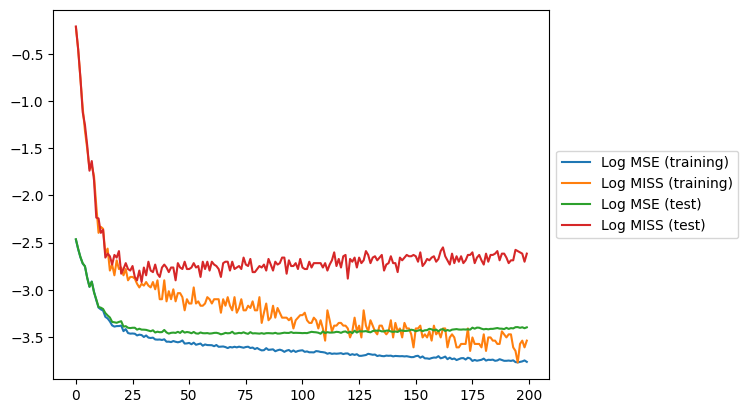

In [13]:
log_train_MSE = np.log(train_mse)
log_train_MISS = np.log(train_miss)
log_test_MSE = np.log(test_mse)
log_test_MISS = np.log(test_miss)

plt.plot(log_train_MSE)
plt.plot(log_train_MISS)
plt.plot(log_test_MSE)
plt.plot(log_test_MISS)

plt.legend(
    ["Log MSE (training)", "Log MISS (training)", "Log MSE (test)", "Log MISS (test)"],
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)
plt.show()